In [2]:
import sys
sys.path.append('..')

In [83]:
%matplotlib inline
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
import csv
import time
from modules.factory import ohlc_chart
import h5py

### 0. Parameters

In [24]:
FILES = glob('../data/daily futures/*.csv')

In [141]:
WINDOW = 20
num_dim = 5 #open, high, low, close, volume
norm_type = 'abs_diff' 
FILENAME = f'../data/training set/trend-{WINDOW}day-{norm_type}.hdf5'

In [210]:
file = h5py.File(FILENAME, "a")
X = file.create_dataset('X', (0, WINDOW, num_dim), maxshape=(None, WINDOW, num_dim), dtype='float32')
Y = file.create_dataset('Y', (0,),maxshape=(None,), dtype='i')
file.close()

../data/daily futures\NYMEX WTI Crude Oil.csv


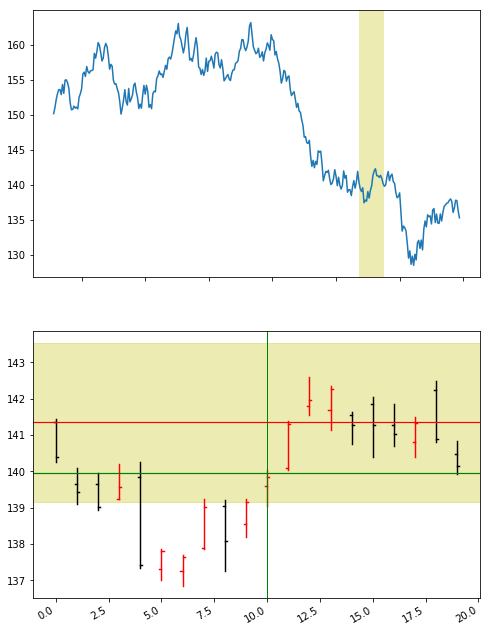

range:  6.67196531792
하락(0), 기타(1), 상승(2): q


In [235]:
file = h5py.File(FILENAME, "a")
X = file['X']
Y = file['Y']
while True:
    idx = np.random.randint(0, len(FILES))

    raw_data  = pd.read_csv(FILES[idx])
    volumes = raw_data['Volume']
    raw_data.drop(['Date', 'Volume','Prev. Day Open Interest'], axis=1, inplace=True)
    length = len(raw_data)
    
    for i in range(10):
        print(FILES[idx])
        #시작일자 랜덤 설정
        start = np.random.randint(0, length -  WINDOW)
        end = start + WINDOW
        data= raw_data[start:end]
        volume = volumes[start:end]   
            
        #Data Normalization
        base = np.abs(data.diff()).mean()
        data = (data-data.mean())/base
        data['volume'] = (volumes[start:end]-volumes[start:end].min())/(volumes[start:end].max() - volumes[start:end].min())
        
        
        #그래프 
        fig, (ax) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1, 1]}, figsize=(8,12))
        fig.autofmt_xdate()
        
        if start < 240:
            start0 = 0
        else:
            start0 = start - 240
            
        if end + 60 < len(raw_data):
            end0 = end + 60
        else:
            end0 = len(raw_data)
        
        ax[0].plot(raw_data.index.values[start0:end0], raw_data.Settle.values[start0:end0])
        ax[0].axvspan(raw_data.index.values[start], raw_data.index.values[end], facecolor='y', alpha=0.3)
        
        ohlc_data = np.concatenate((np.arange(len(data)).reshape(-1, 1), raw_data[start:end].values), axis=1)
        #ax[1].plot(data.index.values, data.values)
        ohlc_chart(ax[1], ohlc_data, linewidth=1.44)
        mean = raw_data[start:end].Settle.mean()
        ax[1].axhline(y=mean, linewidth=1.2, color='g')
        ymin = raw_data.Open.iloc[start]-base.Settle*3
        ymax = raw_data.Open.iloc[start]+base.Settle*3
        ax[1].axhspan(ymin, ymax, alpha=0.3, color='y')
        ax[1].axhline(y=raw_data.Open.iloc[start], linewidth=1.2, color='red')
        ax[1].axvline(x=int(len(data)/2), linewidth=1, color='g')
        plt.show()
    
        #추세 입력
        time.sleep(0.1)
        print('range: ',data.Settle.max() - data.Settle.min())
        trend = input("하락(0), 기타(1), 상승(2): ")
        if trend == 'q' or trend == 'n':
            break
        elif trend in ['0','1','2']:
            size = X.shape[0]
            X.resize(size+1, axis=0)
            Y.resize(size+1, axis=0)
            X[size] = data.values
            Y[size] = int(trend)
            
        clear_output(wait=True)
    if trend == 'q':
            file.close()
            break
    clear_output(wait=True)

In [236]:
file = h5py.File(FILENAME, "a")
X = file['X']
Y = file['Y']

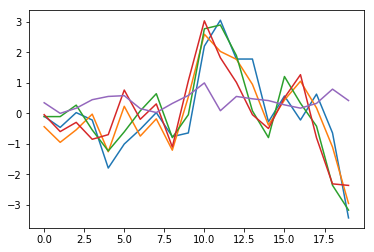

In [241]:
plt.plot(X[10])

In [242]:
Y[10]

1